In [2]:
!pip install lxml
!pip install bs4
from bs4 import BeautifulSoup

import re
import xml.sax.saxutils as saxutils

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
import matplotlib.ticker as mtick

from sklearn.model_selection import train_test_split

# use GPU
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[2], 'GPU')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vgkortsas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/vgkortsas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Functions that help to extract classes

In [3]:
ver='GRU_1_layer'

def remove_tags(text):
    return re.sub('<[^<]+>', '', text).strip() # reference: https://stackoverflow.com/questions/12823568/python-strip-xml-tags-from-document

folder = './reuters21578/'

# files that have the classes
# we save the files in a dictionary where key is the category (i.e. topics, places, people, organizations, exchanges)
# each categoty has different classes (labels)
classes_files = {
    'Topics_': 'all-topics-strings.lc.txt',
    'Places_': 'all-places-strings.lc.txt',
    'People_': 'all-people-strings.lc.txt',
    'Organizations_': 'all-orgs-strings.lc.txt',
    'Exchanges_': 'all-exchanges-strings.lc.txt'
}


# we save the categories and the classes and initiate (i.e 0) a counter, 
# which measures the number of documents thet each class appears. 
# We will use that for our dataframe
classes = []

for key in classes_files.keys():
    with open(folder + classes_files[key], 'r') as file:
        for class_ in file.readlines():
            classes.append([key[:-1], key.lower() + class_.strip().lower(), 0])  # strip() to remove the leading and trailing characters
  
# create a dataframe
classes_df = pd.DataFrame(data=classes, columns=['category', 'class','number_of_documents'])

# for each document we read the classes 
def create_doc_classes(doc_):
    
    topics = doc_.topics.contents
    places = doc_.places.contents
    people = doc_.people.contents
    orgs = doc_.orgs.contents
    exchanges = doc_.exchanges.contents
        
    doc_classes=[]
    for topic in topics:
        doc_classes.append('topics_' + remove_tags(str(topic)))
                
    for place in places:
        doc_classes.append('places_' + remove_tags(str(place)))
                
    for person in people:
        doc_classes.append('people_' + remove_tags(str(person)))
                
    for org in orgs:
        doc_classes.append('organizations_' + remove_tags(str(org)))
                
    for exchange in exchanges:
        doc_classes.append('exchanges_' + remove_tags(str(exchange)))
                
    return doc_classes
   
    
# populate the dataframe, i.e. count in how many documents each class appears
def populate_df(classes_):
    for class_ in classes_:
        idx = classes_df[classes_df['class'] == class_].index[0]
        count = classes_df._get_value(idx, 'number_of_documents')
        classes_df._set_value(idx, 'number_of_documents', count+1)
        

# since each document can belong to multiple classes, we have a multi-class, multi-label classification problem, 
# so we need to do multi-hot encoding
def multi_hot_encoding(classes_, target_classes):
    multi_hot_vector = np.zeros(len(target_classes)).astype(np.float32)
    
    for i in range(len(target_classes)):
        # we set as 1 the element of the vector which corresponds to one of the document classes
        if target_classes[i] in classes_:
            multi_hot_vector[i] = 1.0
    
    return multi_hot_vector

# Process the documents to extract features and classes

In [4]:
# top 20 classes
selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
 'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
 'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
 'topics_corn', 'places_china']

# top 40 classes

# selected_classes = ['places_usa', 'topics_earn', 'topics_acq', 'places_uk', 'places_japan', 'places_canada', 'topics_money-fx',
#  'topics_crude', 'topics_grain', 'places_west-germany', 'topics_trade', 'topics_interest',
#  'places_france', 'organizations_ec', 'places_brazil', 'topics_wheat', 'topics_ship', 'places_australia',
#  'topics_corn', 'places_china', 'topics_dlr', 'places_ussr', 'places_switzerland', 'places_belgium', 'places_netherlands', 
# 'topics_oilseed', 'topics_money-supply', 'topics_sugar', 'places_iran', 'places_italy', 'people_james-baker', 'people_reagan',
# 'topics_gnp', 'topics_coffee', 'places_hong-kong', 'topics_veg-oil', 'places_philippines', 'topics_gold', 
# 'topics_nat-gas', 'places_taiwan']

doc_X = []
doc_Y = []

# read the SGML files
number_of_sgml_files = 22
for i in range(number_of_sgml_files):
    file_name = 'reut2-{}.sgm'.format(str(i).zfill(3))
    print('file: %s' % file_name)
    
    with open(folder + file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "lxml")
        
        for doc in content('reuters'):
            
            # Step 1: Extract the text from the document
            doc_body=str(doc('text'))
            # Step 2: Remove tags
            doc_body=remove_tags(str(doc('text')[0]))
            # Step 3: remove 'reuter'
            doc_body=doc_body.replace('reuter', '')
            # Step 4: Remove the next line character
            doc_body=doc_body.replace('\n','')
            # Step 5: remove the end of text character, i.e. &#3
            doc_body = doc_body.replace('&#3','')
            # Step 6: remove escape characters like &lt, &gt
            doc_body = saxutils.unescape(doc_body)
        
            doc_X.append(doc_body)

            doc_classes=create_doc_classes(doc)
            populate_df(doc_classes)
            doc_Y.append(multi_hot_encoding(doc_classes, selected_classes))

file: reut2-000.sgm
file: reut2-001.sgm
file: reut2-002.sgm
file: reut2-003.sgm
file: reut2-004.sgm
file: reut2-005.sgm
file: reut2-006.sgm
file: reut2-007.sgm
file: reut2-008.sgm
file: reut2-009.sgm
file: reut2-010.sgm
file: reut2-011.sgm
file: reut2-012.sgm
file: reut2-013.sgm
file: reut2-014.sgm
file: reut2-015.sgm
file: reut2-016.sgm
file: reut2-017.sgm
file: reut2-018.sgm
file: reut2-019.sgm
file: reut2-020.sgm
file: reut2-021.sgm


# Study and choose the output classes

## Distribution of the number of documents per class

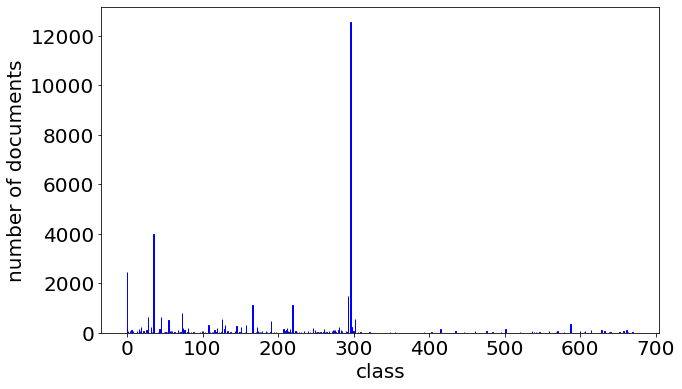

In [5]:
all_classes=range(0,len(classes_df['number_of_documents']))  # 672 classes in total
values = list(classes_df['number_of_documents'])

plt.figure(figsize=(10, 6))
plt.bar(list(all_classes), values, color ='maroon', width = 0.4,ec='blue')
plt.xlabel('class',fontsize=20)
plt.ylabel('number of documents',fontsize=20)
plt.show()

## Since the classes are imbalanced, we classify the documents to the ones that appear most of the time
## Top 20 classes appear in 72% of the documents

In [6]:
num_classes=20
classes_df_sorted=classes_df.sort_values(by='number_of_documents', ascending=False)
classes_df_sorted.head(num_classes)

,category,class,number_of_documents
296,Places,places_usa,12542
35,Topics,topics_earn,3987
0,Topics,topics_acq,2448
293,Places,places_uk,1489
219,Places,places_japan,1138
166,Places,places_canada,1104
73,Topics,topics_money-fx,801
28,Topics,topics_crude,634
45,Topics,topics_grain,628
302,Places,places_west-germany,567


(0.0, 1.0)

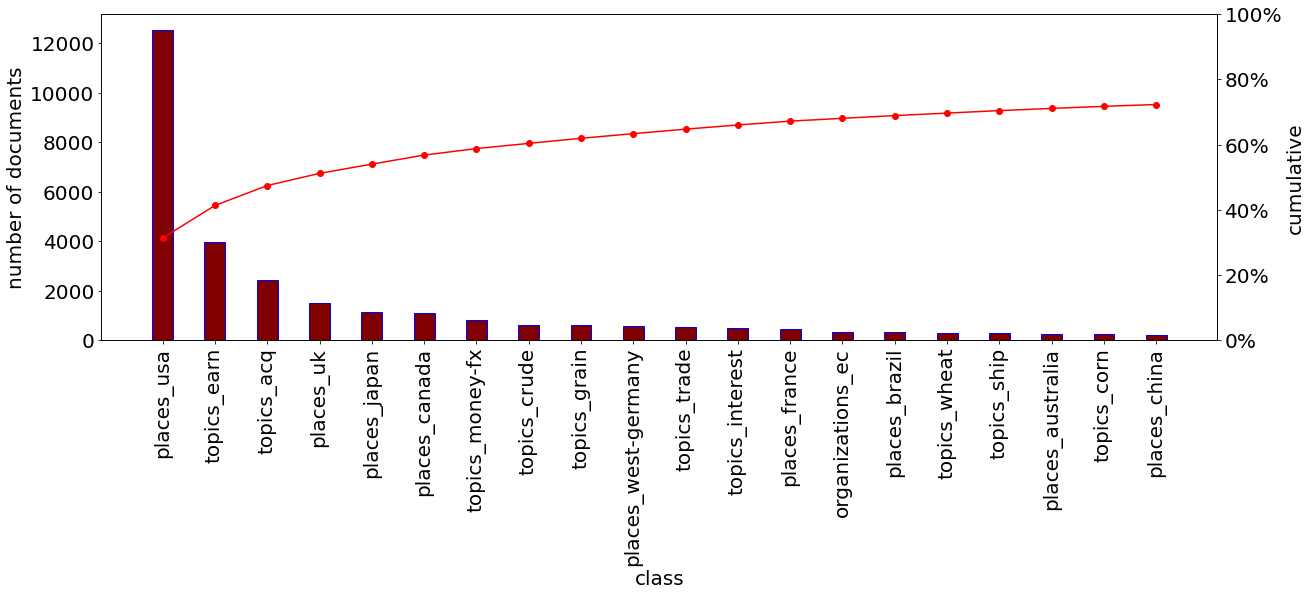

In [7]:
top_classes=range(0,len(classes_df_sorted['number_of_documents'][0:num_classes])) 
top_classes_names=list(classes_df_sorted['class'])[0:num_classes]

values = list(classes_df_sorted['number_of_documents'][0:num_classes])

fig,ax=plt.subplots(figsize=(20, 6))
ax.bar(list(top_classes), values, color ='maroon', width = 0.4,ec='blue')
ax.set_ylabel('number of documents')
ax.set_xlabel('class')
#ax.set_xticks(list(top_classes), top_classes_names)
#ax.set_xticklabels(top_classes_names,rotation=90)
plt.xticks(list(top_classes), top_classes_names, rotation=90)

ax2=ax.twinx()
ax2.plot(list(top_classes), np.cumsum(classes_df_sorted['number_of_documents'][0:num_classes])/np.sum(classes_df_sorted['number_of_documents']),'r-o') # I did not multiply by 100 because of the last command
ax2.set_ylabel('cumulative')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.set_ylim([0,1])
#ax2.set_xticklabels(top_classes_names,rotation=90)

# Process the input features

## Clean the features by keeping the alphanumeric values, doing lematization and removing the stopwords

In [8]:
keep_alphanumeric_chars = re.compile("[^A-Za-z0-9 ]+")
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean(r):
    r = r.lower().replace("<br />", " ")
    r = re.sub(keep_alphanumeric_chars, "", r.lower())
    
    words = word_tokenize(r)
    clean_sequence = []
    for word in words:
        # lematize
        word = lemmatizer.lemmatize(word)
        
        # remove stop words
        if word not in stop_words:
            clean_sequence.append(word)
    return " ".join(clean_sequence)


### Features and classes for a specific document

In [9]:
mmm=210
print(clean(doc_X[mmm]))
print()
print(doc_Y[mmm])

houston oil ho reserve study completed houston feb 26 houston oil trust said independentpetroleum engineer completed annual study estimatesthe trust future net revenue total proved reserve at88 mln dlrs discounted present value reserve at64 mln dlrs based estimate trust said may moneyavailable cash distribution unitholders theremainder year said estimate reflect decrease 44 pct innet reserve revenue 39 pct discounted present valuecompared study made 1985

[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
X = []
for i, doc in enumerate(doc_X):
    X.append(clean(doc))
    
Y = np.array(doc_Y)

## Maximum document length 

In [11]:
document_length = [len(word_tokenize(x)) for x in X]
sorted_document_length=sorted(document_length)
max_document_length = sorted_document_length[-1]
print("maximum document length: ",max_document_length)

maximum document length:  1499


## Choose as document length the one that 90% of the documents have

90.0% of documents have maximum length  177


(0.0, 1.0)

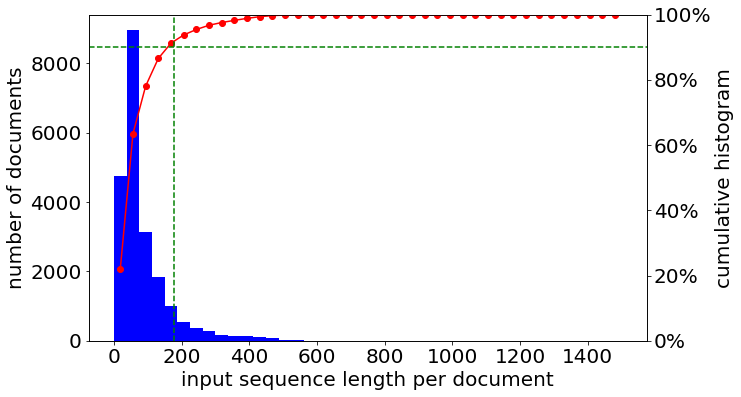

In [12]:
percent_=0.9
max_document_length = sorted_document_length[int(len(sorted_document_length) * percent_)]
print(str(percent_*100)+"% of documents have maximum length ",max_document_length)

fig,ax=plt.subplots(figsize=(10, 6))
counts, bins, _ = ax.hist(sorted_document_length,color='b', bins=40)
bin_centers = 0.5*(bins[1:] + bins[:-1])

ax.set_xlabel('input sequence length per document')
ax.set_ylabel('number of documents')
ax2=ax.twinx()
ax2.plot(bin_centers,np.cumsum(counts)/np.sum(counts),'r-o') # I did not multiply by 100 because of the last command
ax2.set_ylabel('cumulative histogram')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
ax2.axhline(y=percent_,color='g',linestyle='--')
ax2.axvline(x=max_document_length,color='g',linestyle='--')

ax2.set_ylim([0,1])
# ax2.set_xlim([0,100])
# ax.set_xlim([0,100])

## Tokenize the words

In [13]:
total_words=[]
for kkk in range(len(X)):
    words_per_doc=X[kkk].split()
    total_words.extend(words_per_doc)
    
num_unique_words=len(np.unique(total_words))
print('number of unique words:',num_unique_words)

max_vocab_size = num_unique_words
tokenizer = Tokenizer(max_vocab_size)
tokenizer.fit_on_texts(X)
input_vocab_size = len(tokenizer.word_index) + 1 
# +1 Because tokenizer.word_index is a python dictionary that contains token keys (string) and token ID values (integer), 
# and where the first token ID is 1 (not zero) and where the token IDs are assigned incrementally. 
# Therefore, the greatest token ID in word_index is len(word_index). 
# Therefore, we need vocabulary of size len(word_index) + 1 to be able to index up to the greatest token ID.
print("input_vocab_size:",input_vocab_size)

number of unique words: 173187
input_vocab_size: 173188


## Pad each document sentence so all of them have the same length 

In [14]:
X = np.array(pad_sequences(tokenizer.texts_to_sequences(X), maxlen=max_document_length))

# Model

### The model consists of an embedding layer, a GRU layer and a dense output laye. The number of neurons of the output layer is equal to the number of the most frequent classes (20 in our case).

###  Since we have a multi-class, multi-label classification problem, the probability of each class is independent of the probability of the others. Thus, we use the sigmoid activation function at the final layer in order to get the probability that the input features belong to a specific class or not.

### Consequently, The loss function is the binary cross entropy loss function. 



In [16]:
hidden_units=128

embedding_dim = 256
model = Sequential()
model.add(Embedding(input_vocab_size, embedding_dim,input_length = max_document_length))
model.add(GRU(hidden_units))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 177, 256)          44336128  
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2580      
Total params: 44,486,548
Trainable params: 44,486,548
Non-trainable params: 0
_________________________________________________________________


# Train the model

## plot train and validation loss/accuracy and choose the model which corresponds to the smallest validation loss

In [17]:
num_epochs=20

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

checkpoint_name='best_checkpoint_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.hdf5'
model_checkpoint_callback = ModelCheckpoint(
     filepath=checkpoint_name,
     save_weights_only=True,
     monitor='val_loss',
     mode='min',
     save_best_only=True)
    
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=128, epochs=num_epochs, callbacks=[model_checkpoint_callback])

modelname = 'weights_at_last_epoch_'+str(ver)+'_'+str(hidden_units)+'_'+str(num_epochs)+'.hdf5'
model.save_weights(modelname)

/home/vgkortsas/.conda/envs/VOI/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 15535 samples, validate on 1727 samples
Epoch 1/20


2022-04-21 16:30:05.513081: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10


15535/15535 [==============================] - 18s 1ms/step - loss: 0.2537 - accuracy: 0.9263 - val_loss: 0.1683 - val_accuracy: 0.9473
Epoch 2/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.1636 - accuracy: 0.9493 - val_loss: 0.1352 - val_accuracy: 0.9602
Epoch 3/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.1254 - accuracy: 0.9623 - val_loss: 0.1151 - val_accuracy: 0.9647
Epoch 4/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.1009 - accuracy: 0.9682 - val_loss: 0.1015 - val_accuracy: 0.9679
Epoch 5/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.0789 - accuracy: 0.9744 - val_loss: 0.0910 - val_accuracy: 0.9705
Epoch 6/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.0592 - accuracy: 0.9804 - val_loss: 0.0826 - val_accuracy: 0.9736
Epoch 7/20
15535/15535 [==============================] - 18s 1ms/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 0.0785 - val

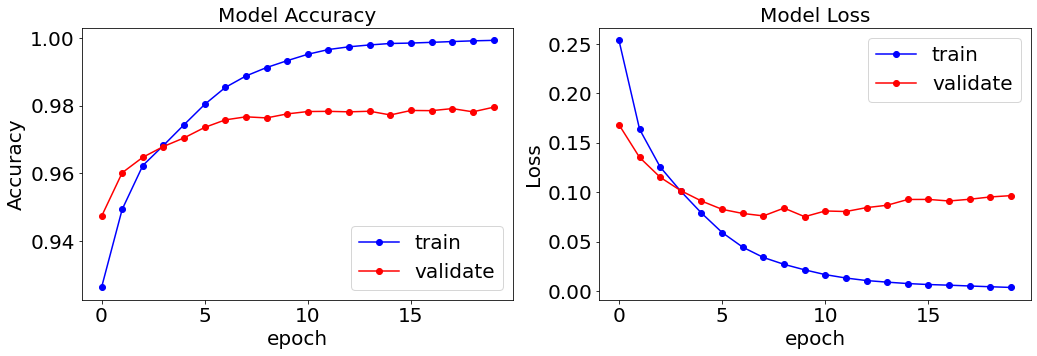

In [18]:
plt.figure(figsize=(17, 5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'b-o') 
plt.plot(history.history['val_accuracy'],'r-o') 
plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20) 
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validate'], loc='lower right')
plt.subplot(1,2,2)
plt.plot(history.history['loss'], 'b-o') 
plt.plot(history.history['val_loss'],'r-o') 
plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20) 
plt.xlabel('epoch',fontsize=20)
plt.legend(['train', 'validate'], loc='upper right')


plt.savefig('losses_GRU_1_layer' + '_' + str(hidden_units)+ '_' + str(num_epochs) + '.png')
plt.show()

# save file
dict_losses = {'accuracy' : history.history['accuracy'], 'val_accuracy': history.history['val_accuracy'], 
               'loss' :history.history['loss'], 'val_loss' :history.history['val_loss']}
f = open('dict_losses_GRU_1_layer_'+str(hidden_units)+'_'+str(num_epochs)+'.txt',"w")
f.write( str(dict_losses) )
f.close()

# Test the model

In [19]:
score, acc = model.evaluate(X_test, Y_test, batch_size=128)
    
print('Test loss: %1.4f' % score)
print('Test accuracy: %1.4f' % acc)

4316/4316 [==============================] - 1s 212us/step
Test loss: 0.0973
Test accuracy: 0.9791


## Since the classes are imbalanced, accuracy is not the best metric to evaluate the model on test data. Thus, we calculate precision, recall and F1 score

In [20]:
from sklearn.metrics import f1_score, precision_score, recall_score

model.load_weights(checkpoint_name)
Y_pred=model.predict(X_test)

# convert Y_pred to 0 and 1
Y_pred_0_1=np.zeros(Y_pred.shape)
for kkk in range(len(Y_pred_0_1)):
    Y_pred_0_1[kkk]=(Y_pred[kkk]>0.5).astype(int) # we use 0.5 as the threshold
    
precision=precision_score(Y_test,Y_pred_0_1,average='micro')
recall=recall_score(Y_test,Y_pred_0_1,average='micro')
f1=f1_score(Y_test,Y_pred_0_1,average='micro')

print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))
print('F1-measure: {:.4f}'.format(f1))


# save file
dict_scores = {'Precision' : precision, 'Recall': recall, 'F1-measure' :f1}
f = open('dict_scores_GRU_1_layer_'+str(hidden_units)+'_'+str(num_epochs)+'.txt',"w")
f.write( str(dict_scores) )
f.close()


Precision: 0.8972
Recall: 0.7507
F1-measure: 0.8174
